# Module enrichment 

In [ ]:
library_load <- suppressMessages(
    list(
        
        # Seurat 
        library(Seurat), 
        
        # Data 
        library(dplyr), 
        
        # Genomic
        library(TxDb.Mmusculus.UCSC.mm10.knownGene), 
        library(ChIPseeker), 
        library(rtracklayer), 
        library(GenomicRanges),
        
        # Plotting 
        library(ggplot2), 
        library(patchwork)
        
        
    )
)

In [ ]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [ ]:
# Source files
source("plotting_global.R")

In [ ]:
options(warn=-1)

# Parameter settings

In [ ]:
so_file <- "data/object/qc/so_qc_treatment_reg.rds"

# Import Seurat 

In [ ]:
so <- readRDS(so_file)

# Transcription factor 

## Get STAT1 genomic regions from the UniBind data bank

In [ ]:
meta <- read.delim("data/unibind/meta_mus_musculus.tsv")

In [ ]:
meta <- meta[meta$tf_name == "STAT1", ]
meta <- meta[grep("BMDM|bone marrow-derived macrophages", meta$title), ]

In [ ]:
meta_crt <- meta[grep("", meta$biological_condition), ]
meta_ifnb <- meta[grep("IFNb|IFNbeta|IFNβ", meta$biological_condition), ]
meta_ifng <- meta[grep("IFNg|IFNgamma|IFNγ", meta$biological_condition), ]

In [ ]:
import_bed <- function(meta) {
    
    # Get list of bed file path 
    unibind <- list.files("data/unibind/robust/Mus_musculus/damo_mm10_TFBS_per_TF/", recursive = TRUE, full.names = TRUE)
    
    # Register GRangesList for bed file inport 
    gr <- list()
    for (bed_file in meta$bed_filename) {
        
        bed_paths <- unibind[grep(strsplit(bed_file, "\\.")[[1]][1], unibind)]
        
        for (bed_path in bed_paths) {
            
            gr[[bed_path]] <- rtracklayer::import(bed_path)
            
        }
        

    }
    
    gr <- reduce(unlist(as(gr, "GRangesList")))
    
}

In [ ]:
gr_crt <- import_bed(meta_crt)
gr_ifnb <- import_bed(meta_ifnb)
gr_ifng <- import_bed(meta_ifng)

In [ ]:
length(gr_crt)
length(gr_ifnb)
length(gr_ifng)

## Annotate the Stat1 regions with genes 

In [ ]:
anno_gr <- function(gr) {
    
    anno <- annotatePeak(
        
        gr, 
        tssRegion=c(-1000, 1000),
        TxDb=TxDb.Mmusculus.UCSC.mm10.knownGene, 
        annoDb="org.Mm.eg.db", 
        level="gene", 
        verbose=FALSE
    
    )
    
    return(anno)
    
}


In [ ]:
anno_ctr <- anno_gr(gr_crt)
anno_ifnb <- anno_gr(gr_ifnb)
anno_ifng <- anno_gr(gr_ifng)

In [ ]:
genes_ctr <- anno_ctr@anno$SYMBOL
genes_ifnb <- anno_ifnb@anno$SYMBOL
genes_ifng <- anno_ifng@anno$SYMBOL

In [ ]:
genes_ctr <- genes_ctr[anno_ctr@detailGenomicAnnotation$Promoter == TRUE] %>% unique()
genes_ifnb <- genes_ifnb[anno_ifnb@detailGenomicAnnotation$Promoter == TRUE] %>% unique()
genes_ifng <- genes_ifng[anno_ifng@detailGenomicAnnotation$Promoter == TRUE] %>% unique()

In [ ]:
length(genes_ctr)
length(genes_ifnb)
length(genes_ifng)

# Get module scores

In [ ]:
module_score <- function(so) {
    
    so <- AddModuleScore(so, features=list(genes_ctr), assays="RNA", slot="data", ctrl=100, nbin=25, name="msSTAT1_ctr")
    so <- AddModuleScore(so, features=list(genes_ifnb), assays="RNA", slot="data", ctrl=100, nbin=25, name="msSTAT1_IFNb")
    so <- AddModuleScore(so, features=list(genes_ifng), assays="RNA", slot="data", ctrl=100, nbin=25, name="msSTAT1_IFNg")
    so <- AddModuleScore(so, features=list("Stat1"), assays="RNA", slot="data", ctrl=100, nbin=25, name="msSTAT1")
    so <- AddModuleScore(so, features=list(c("Jak1", "Jak2", "Jak3")), assays="RNA", slot="data", ctrl=100, nbin=25, name="msJAK")
    so <- AddModuleScore(so, features=list(rownames(so)[grep("Ifnar", rownames(so))]), assays="RNA", slot="data", ctrl=100, nbin=25, name="msIFNAR")
    
    return(so)
    
}

so <- lapply(so, module_score)

# Gene module feature plots 

In [ ]:
feature_plot <- function(so) {
    
    fplot_1 <- FeaturePlot(so, reduction = "umap", features = "msIFNAR1", cols = c("white", RColorBrewer::brewer.pal(5, "PuOr")[5])) & theme(aspect.ratio = 1) & ggtitle("Ifnar")
    fplot_2 <- FeaturePlot(so, reduction = "umap", features = "msSTAT11", cols = c("white", RColorBrewer::brewer.pal(5, "PuOr")[5])) & theme(aspect.ratio = 1) & ggtitle("Stat1")
    fplot_3 <- FeaturePlot(so, reduction = "umap", features = "msJAK1", cols = c("white", RColorBrewer::brewer.pal(5, "PuOr")[5])) & theme(aspect.ratio = 1) & ggtitle("Jak1-3")
    fplot_4 <- FeaturePlot(so, reduction = "umap", features = "msSTAT1_ctr1", cols = c("white", RColorBrewer::brewer.pal(5, "PuOr")[1])) & theme(aspect.ratio = 1) & ggtitle("STAT1 (BMDM Ctr)")
    fplot_5 <- FeaturePlot(so, reduction = "umap", features = "msSTAT1_IFNb1", cols = c("white", RColorBrewer::brewer.pal(5, "PuOr")[1])) & theme(aspect.ratio = 1) & ggtitle("STAT1 (BMDM IFNb)")
    fplot_6 <- FeaturePlot(so, reduction = "umap", features = "msSTAT1_IFNg1", cols = c("white", RColorBrewer::brewer.pal(5, "PuOr")[1])) & theme(aspect.ratio = 1) & ggtitle("STAT1 (BMDM IFNg)")

    fplot <- fplot_1 + fplot_2 + fplot_3 + fplot_4 + fplot_5 + fplot_6 + plot_layout(ncol = 3)
    
    return(fplot)
}

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
fplot_nacl <- feature_plot(so[["NaCl"]])
fplot_nacl
ggsave(fplot_nacl, filename="result/plot/module_enrichment/stat1_nacl.png", width=15, height=10)

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
fplot_cpg <- feature_plot(so[["CpG"]])
fplot_cpg
ggsave(fplot_cpg, filename="result/plot/module_enrichment/stat1_cpg.png", width=15, height=10)

# Lab meeting figures 

In [7]:
source("bin/SeuratQC.R")

In [ ]:
options(repr.plot.width=15, repr.plot.height=5)
dplot_nacl <- dim_plot_short(so[["NaCl"]])
dplot_nacl
ggsave(dplot_nacl, filename="result/plot/module_enrichment/dplot_nacl.png", width=15, height=5)

In [ ]:
options(repr.plot.width=15, repr.plot.height=5)
dplot_cpg <- dim_plot_short(so[["CpG"]])
dplot_cpg
ggsave(dplot_cpg, filename="result/plot/module_enrichment/dplot_cpg.png", width=15, height=5)

### Cell cycle 

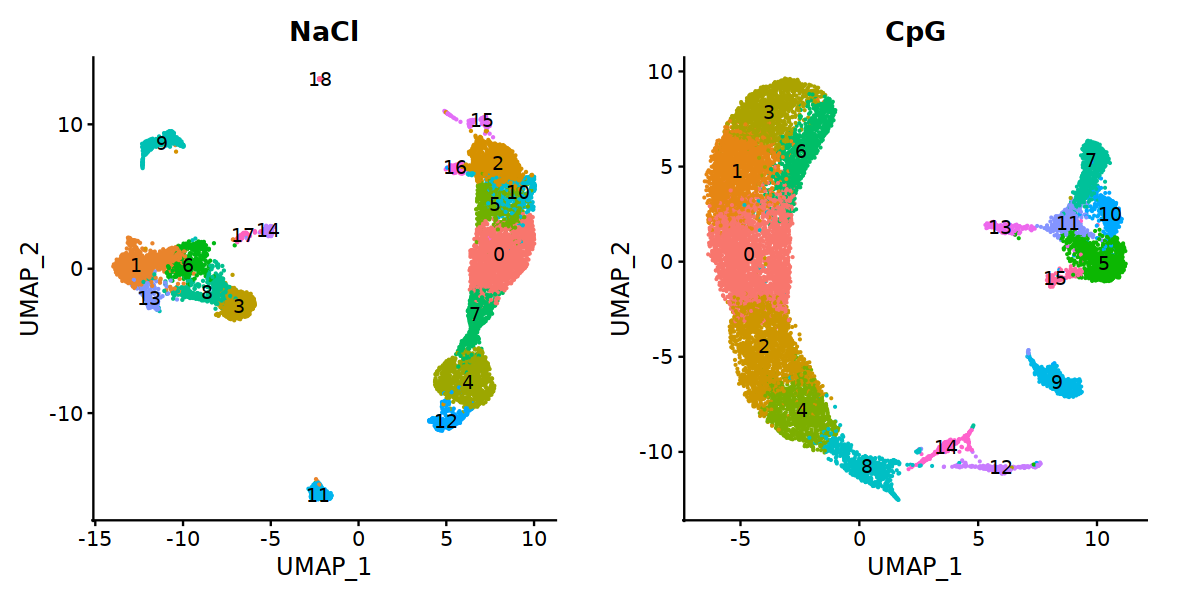

In [16]:
options(repr.plot.width=10, repr.plot.height=5)

dplot_1 <- DimPlot(so[["NaCl"]], reduction = "umap", group.by = "SCT_snn_res.0.8", label = TRUE) & 
        theme(aspect.ratio = 1, legend.position = "none") &
        ggtitle("NaCl")

dplot_2 <- DimPlot(so[["CpG"]], reduction = "umap", group.by = "SCT_snn_res.0.8", label = TRUE) & 
        theme(aspect.ratio = 1, legend.position = "none") & 
        ggtitle("CpG")

# Combine plots 
dplot <- dplot_1 + dplot_2 + plot_layout(ncol = 2)
dplot
ggsave(dplot, filename="result/plot/module_enrichment/cc_cluster.png", width=10, height=5)